In [1]:
import pandas as pd

matches = pd.read_csv("matches.csv", parse_dates=["date"])
players = pd.read_csv("players.csv")
attr    = pd.read_csv("players_attributes.csv")

print("Matches:", matches.shape)
print("Players:", players.shape)
print("Attributes:", attr.shape)
matches.head(), players.head(), attr.head()


Matches: (10007, 57)
Players: (20458, 4)
Attributes: (12247, 35)


(        date   homePlayer1      homePlayer2        homePlayer3  \
 0 2016-01-02        Adrián  Aaron Cresswell      James Tomkins   
 1 2016-01-02   Declan Rudd   Russell Martin  Sébastien Bassong   
 2 2016-01-02  David de Gea       Phil Jones          Juan Mata   
 3 2016-01-02     Petr Čech  Per Mertesacker  Laurent Koscielny   
 4 2016-01-02   Boaz Myhill    Claudio Yacob        Jonny Evans   
 
         homePlayer4        homePlayer5     homePlayer6  \
 0  Cheikhou Kouyaté       Andy Carroll  Manuel Lanzini   
 1      Jonny Howson  Dieumerci Mbokani    Robbie Brady   
 2      Wayne Rooney    Anthony Martial  Chris Smalling   
 3        Mesut Özil     Olivier Giroud    Theo Walcott   
 4    James Morrison      Craig Gardner     Chris Brunt   
 
                homePlayer7     homePlayer8      homePlayer9  ... homeThrowIns  \
 0           Enner Valencia      Mark Noble    James Collins  ...          NaN   
 1             Wes Hoolahan  Nathan Redmond     Ryan Bennett  ...          N

In [2]:
import numpy as np
attr["PlayerID"]    = attr["ID"].str.extract(r"^(.+/\d+/)")
players["PlayerID"] = players["ID"].str.extract(r"^(.+/\d+/)")
p = players[["PlayerID","Name"]].merge(attr, on="PlayerID", how="inner")
skill_cols = [c for c in p.select_dtypes("number").columns if c!="FIFA"]

def avg_skill(row, side):
    names = [row[f"{side}Player{i}"] for i in range(1,12)]
    skills = p[p["Name"].isin(names)][skill_cols]
    return skills.stack().mean() if not skills.empty else np.nan

matches["lineup_size_home"] = matches[[f"homePlayer{i}" for i in range(1,12)]].notna().sum(axis=1)
matches["lineup_size_away"] = matches[[f"awayPlayer{i}" for i in range(1,12)]].notna().sum(axis=1)
matches["home_skill"]       = matches.apply(lambda r: avg_skill(r,"home"), axis=1)
matches["away_skill"]       = matches.apply(lambda r: avg_skill(r,"away"), axis=1)
matches["skill_diff"]       = matches["home_skill"] - matches["away_skill"]

matches[["lineup_size_home","lineup_size_away","skill_diff"]].head()


,lineup_size_home,lineup_size_away,skill_diff
0,11,11,1.087995
1,11,11,-2.984174
2,11,11,7.426023
3,11,11,-2.114978
4,11,11,-2.907868


In [3]:
import numpy as np
matches = matches.sort_values("date").reset_index(drop=True)

home = matches[["date","homeTeam","awayTeam","scoreHome","scoreAway"]].rename(
    columns={"homeTeam":"team","awayTeam":"opponent","scoreHome":"goals_for","scoreAway":"goals_against"})
away = matches[["date","awayTeam","homeTeam","scoreAway","scoreHome"]].rename(
    columns={"awayTeam":"team","homeTeam":"opponent","scoreAway":"goals_for","scoreHome":"goals_against"})
allm = pd.concat([home,away], ignore_index=True)

allm["result_bin"] = (allm["goals_for"]>allm["goals_against"]).astype(int)
allm["form_5"] = (allm.groupby("team")["result_bin"]
                  .rolling(5, min_periods=1).mean()
                  .reset_index(level=0, drop=True))

matches["home_form_5"] = matches.apply(
    lambda r: allm[(allm.team==r.homeTeam)&(allm.date<r.date)]["form_5"].iloc[-1]
              if any((allm.team==r.homeTeam)&(allm.date<r.date)) else 0,
    axis=1)
matches["away_form_5"] = matches.apply(
    lambda r: allm[(allm.team==r.awayTeam)&(allm.date<r.date)]["form_5"].iloc[-1]
              if any((allm.team==r.awayTeam)&(allm.date<r.date)) else 0,
    axis=1)

matches["h2h_home_wins"] = matches.apply(
    lambda r: int(allm[(allm.team==r.homeTeam)&
                       (allm.opponent==r.awayTeam)&
                       (allm.date<r.date)]["result_bin"].sum()),
    axis=1)
matches["h2h_away_wins"] = matches.apply(
    lambda r: int(allm[(allm.team==r.awayTeam)&
                       (allm.opponent==r.homeTeam)&
                       (allm.date<r.date)]["result_bin"].sum()),
    axis=1)

teams = pd.unique(matches[["homeTeam","awayTeam"]].values.ravel())
elo   = {t:1500 for t in teams}
K=20; he=[]; ae=[]
for _,r in matches.iterrows():
    Rh,Ra = elo[r.homeTeam], elo[r.awayTeam]
    Eh = 1/(1+10**((Ra-Rh)/400))
    Sh = 1 if r.scoreHome>r.scoreAway else (0.5 if r.scoreHome==r.scoreAway else 0)
    elo[r.homeTeam] = Rh + K*(Sh-Eh)
    elo[r.awayTeam] = Ra + K*((1-Sh)-(1-Eh))
    he.append(elo[r.homeTeam]); ae.append(elo[r.awayTeam])
matches["home_elo"] = he
matches["away_elo"] = ae
matches["elo_diff"] = matches["home_elo"] - matches["away_elo"]


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

matches["result"] = np.select(
    [matches.scoreHome>matches.scoreAway,
     matches.scoreHome<matches.scoreAway],
    [1,0], default=2
)

features = [
  "home_form_5","away_form_5",
  "h2h_home_wins","h2h_away_wins",
  "home_elo","away_elo","elo_diff",
  "lineup_size_home","lineup_size_away","skill_diff"
]
features = [f for f in features if f in matches.columns]

X = matches[features].fillna(0)
y = matches["result"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Features:", features)
print("X_train:", X_train.shape, "X_test:", X_test.shape)


Features: ['home_form_5', 'away_form_5', 'h2h_home_wins', 'h2h_away_wins', 'home_elo', 'away_elo', 'elo_diff', 'lineup_size_home', 'lineup_size_away', 'skill_diff']
X_train: (8005, 10) X_test: (2002, 10)


In [5]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

param_dist = {
  "max_iter":        [100,200,300,400],
  "max_depth":       [3,5,7,None],
  "learning_rate":   [0.005,0.01,0.05,0.1],
  "min_samples_leaf":[20,50,100,200],
  "l2_regularization":[0,0.1,1,5]
}

hgb = HistGradientBoostingClassifier(random_state=42, early_stopping=False)

rand_hgb = RandomizedSearchCV(
    hgb, param_dist, n_iter=30,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring="f1_macro", n_jobs=-1, verbose=1, random_state=42
)
rand_hgb.fit(X_train, y_train)

best_hgb = rand_hgb.best_estimator_
print("Best HGB params:", rand_hgb.best_params_)
print("Best CV macro-F1:", rand_hgb.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best HGB params: {'min_samples_leaf': 50, 'max_iter': 400, 'max_depth': 3, 'learning_rate': 0.05, 'l2_regularization': 1}
Best CV macro-F1: 0.49593397867231


              precision    recall  f1-score   support

    Away win       0.55      0.70      0.62       597
    Home win       0.63      0.74      0.68       887
        Draw       0.39      0.16      0.23       518

    accuracy                           0.58      2002
   macro avg       0.53      0.53      0.51      2002
weighted avg       0.55      0.58      0.55      2002



/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


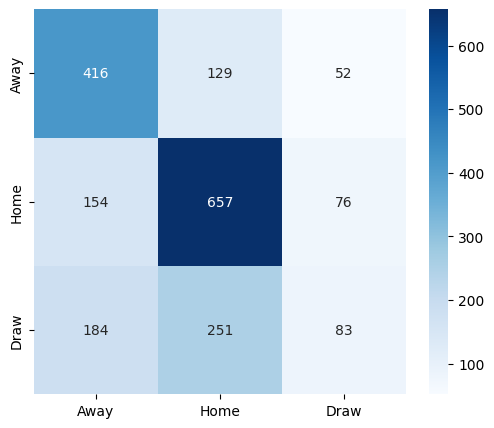

In [6]:
from sklearn.pipeline       import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier, VotingClassifier
from sklearn.metrics        import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

rf = RandomForestClassifier(
    n_estimators=200, max_depth=7,
    class_weight="balanced", random_state=42, n_jobs=-1
)
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver="saga", max_iter=2000,
                       class_weight="balanced", random_state=42)
)

vot = VotingClassifier(
    estimators=[("hgb", best_hgb), ("rf", rf), ("lr", pipe_lr)],
    voting="soft", weights=[3,2,1], n_jobs=-1
)
vot.fit(X_train, y_train)

y_pred = vot.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=["Away win","Home win","Draw"]))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",
            xticklabels=["Away","Home","Draw"],
            yticklabels=["Away","Home","Draw"])
plt.show()


Optimum t_draw=0.170, F1(Draw)=0.434
              precision    recall  f1-score   support

    Away win       0.74      0.18      0.28       597
    Home win       0.82      0.23      0.36       887
        Draw       0.29      0.89      0.43       518

    accuracy                           0.39      2002
   macro avg       0.62      0.43      0.36      2002
weighted avg       0.66      0.39      0.36      2002



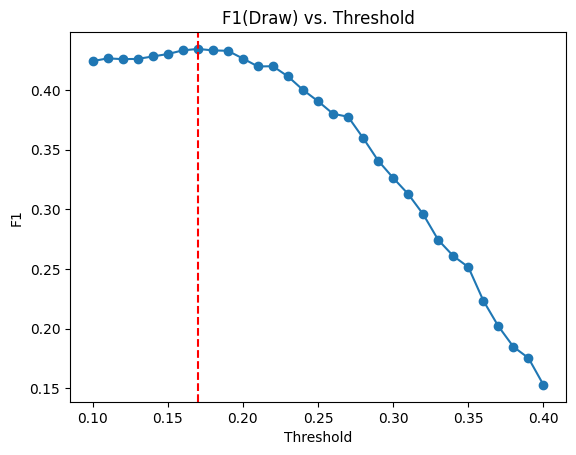

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report

probs = best_hgb.predict_proba(X_test)

thresholds = np.linspace(0.1,0.4,31)
best_t, best_f1 = 0, -1
for t in thresholds:
    preds = [2 if p[2]>t else np.argmax(p[:2]) for p in probs]
    f1d = f1_score(y_test, preds, labels=[2], average="macro")
    if f1d>best_f1:
        best_f1, best_t = f1d, t
print(f"Optimum t_draw={best_t:.3f}, F1(Draw)={best_f1:.3f}")

y_tuned = [2 if p[2]>best_t else np.argmax(p[:2]) for p in probs]
print(classification_report(
    y_test, y_tuned,
    target_names=["Away win","Home win","Draw"]
))
plt.plot(thresholds, [f1_score(y_test, [2 if p[2]>t else np.argmax(p[:2]) for p in probs],
                               labels=[2], average="macro") for t in thresholds],
         marker="o")
plt.axvline(best_t, color="red", linestyle="--")
plt.title("F1(Draw) vs. Threshold"); plt.xlabel("Threshold"); plt.ylabel("F1"); plt.show()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CatBoost params: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 8}
CV macro-F1: 0.4942818814722479
              precision    recall  f1-score   support

    Away win       0.55      0.66      0.60       597
    Home win       0.61      0.77      0.68       887
        Draw       0.39      0.13      0.20       518

    accuracy                           0.57      2002
   macro avg       0.52      0.52      0.49      2002
weighted avg       0.54      0.57      0.53      2002



<Axes: >

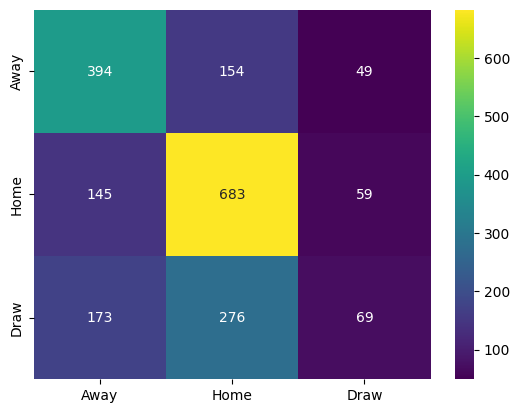

In [9]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

features_cb = features
X_cb, y_cb = X_train.copy(), y_train.copy()

cbc = CatBoostClassifier(
    task_type="CPU", eval_metric="MultiClass",
    verbose=False, random_state=42
)
param_dist = {
    "depth":        [4,6,8,10],
    "learning_rate":[0.01,0.05,0.1],
    "l2_leaf_reg":  [1,3,5,7],
    "iterations":   [100,200,500]
}

rand_cbc = RandomizedSearchCV(
    cbc, param_dist, n_iter=20,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring="f1_macro", n_jobs=-1, random_state=42, verbose=1
)
rand_cbc.fit(X_train, y_train)

best_cbc = rand_cbc.best_estimator_
print("Best CatBoost params:", rand_cbc.best_params_)
print("CV macro-F1:", rand_cbc.best_score_)

# 8.3 Оценка
y_pred_cb = best_cbc.predict(X_test)
print(classification_report(y_test, y_pred_cb,
      target_names=["Away win","Home win","Draw"]))
cm_cb = confusion_matrix(y_test, y_pred_cb)
sns.heatmap(cm_cb, annot=True, fmt="d", cmap="viridis",
            xticklabels=["Away","Home","Draw"], yticklabels=["Away","Home","Draw"])


/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-

Macro-F1 (TE+TSNE): 0.5029841048503304
              precision    recall  f1-score   support

        Away       0.56      0.60      0.58       597
        Home       0.61      0.75      0.67       887
        Draw       0.36      0.20      0.26       518

    accuracy                           0.56      2002
   macro avg       0.51      0.51      0.50      2002
weighted avg       0.53      0.56      0.54      2002



<Axes: >

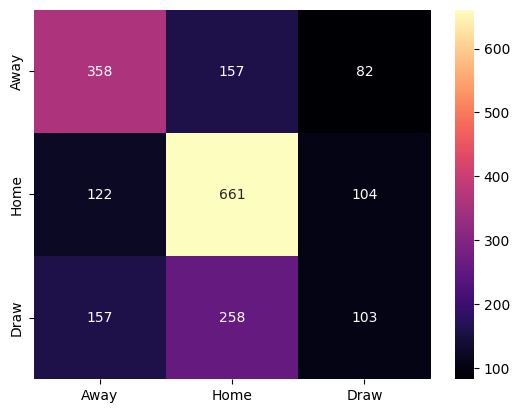

In [10]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

features_num = features
cats         = ["homeTeam","awayTeam"]

X_raw = matches[features_num + cats].copy()
y_raw = matches["result"]

global_mean = y_raw.mean()
home_te = matches.groupby("homeTeam")["result"].mean()
away_te = matches.groupby("awayTeam")["result"].mean()
X_raw["homeTeam_te"] = X_raw["homeTeam"].map(home_te).fillna(global_mean)
X_raw["awayTeam_te"] = X_raw["awayTeam"].map(away_te).fillna(global_mean)

te_feats = ["homeTeam_te","awayTeam_te"]
emb = TSNE(n_components=2, random_state=42).fit_transform(X_raw[te_feats])
X_raw["team_tsne1"], X_raw["team_tsne2"] = emb[:,0], emb[:,1]

X_train9, X_test9, y_train9, y_test9 = train_test_split(
    X_raw[features_num+te_feats+["team_tsne1","team_tsne2"]].fillna(0),
    y_raw, test_size=0.2, random_state=42, stratify=y_raw
)
hgb9 = HistGradientBoostingClassifier(random_state=42).fit(X_train9, y_train9)
y_pred9 = hgb9.predict(X_test9)

print("Macro-F1 (TE+TSNE):", f1_score(y_test9, y_pred9, average="macro"))
print(classification_report(y_test9, y_pred9,
      target_names=["Away","Home","Draw"]))
cm9 = confusion_matrix(y_test9, y_pred9)
sns.heatmap(cm9, annot=True, fmt="d", cmap="magma",
            xticklabels=["Away","Home","Draw"], yticklabels=["Away","Home","Draw"])


STACKING Macro-F1: 0.48601460143833725
              precision    recall  f1-score   support

        Away       0.56      0.69      0.62       597
        Home       0.61      0.80      0.69       887
        Draw       0.43      0.09      0.15       518

    accuracy                           0.58      2002
   macro avg       0.53      0.53      0.49      2002
weighted avg       0.55      0.58      0.53      2002



/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/arsenijgrazdancev/PyCharmMiscProject/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_predi

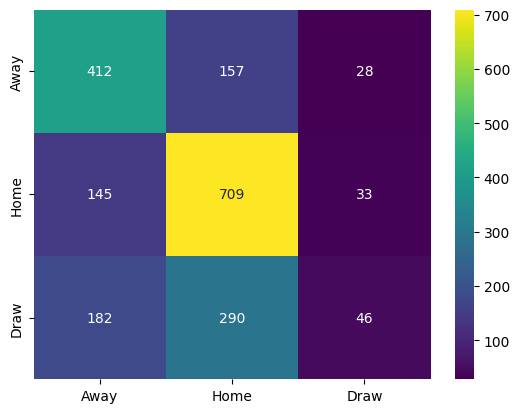

In [11]:
import numpy as np
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics        import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_hgb_params = rand_hgb.best_params_
best_rf_params  = {
    "n_estimators":200, "max_depth":10,
    "min_samples_leaf":3, "class_weight":"balanced",
    "random_state":42
}

models = {
    "hgb": HistGradientBoostingClassifier(**best_hgb_params, random_state=42),
    "rf" : RandomForestClassifier(**best_rf_params)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_train, n_test = X_train.shape[0], X_test.shape[0]
n_classes = len(np.unique(y_train))
n_models  = len(models)

meta_train = np.zeros((n_train,  n_models*n_classes))
meta_test  = np.zeros((n_test,   n_models*n_classes))

for idx,(name,mdl) in enumerate(models.items()):
    proba_cv = cross_val_predict(
        mdl, X_train, y_train, cv=skf,
        method="predict_proba", n_jobs=-1
    )
    start, end = idx*n_classes, (idx+1)*n_classes
    meta_train[:, start:end] = proba_cv

    mdl.fit(X_train, y_train)
    meta_test[:,  start:end] = mdl.predict_proba(X_test)

meta_cols = [f"{m}_p{c}" for m in models for c in range(n_classes)]
meta_train_df = pd.DataFrame(meta_train, columns=meta_cols, index=X_train.index)
meta_test_df  = pd.DataFrame(meta_test,  columns=meta_cols, index=X_test.index)

meta_model = LogisticRegression(
    multi_class="multinomial", solver="lbfgs",
    max_iter=500, random_state=42
)
meta_model.fit(meta_train_df, y_train)

y_pred_meta = meta_model.predict(meta_test_df)
print("STACKING Macro-F1:", f1_score(y_test, y_pred_meta, average="macro"))
print(classification_report(y_test, y_pred_meta,
      target_names=["Away","Home","Draw"]))
cm10 = confusion_matrix(y_test, y_pred_meta)
sns.heatmap(cm10, annot=True, fmt="d", cmap="viridis",
            xticklabels=["Away","Home","Draw"], yticklabels=["Away","Home","Draw"])
plt.show()
